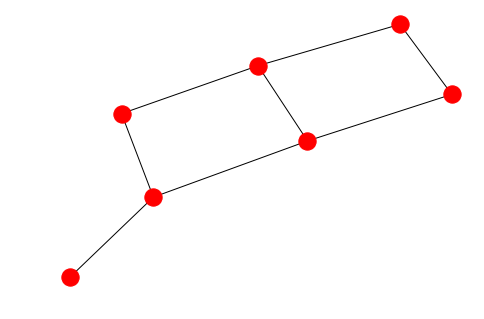

Graphs
[(1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 6), (5, 6), (5, 7)]
8
EDGE_REMOVED:
(0, 0)
Number of componeents:
1
true
1 2
{'weight': 5.999999999999999}
1 3
{'weight': 10.666666666666666}
2 4
{'weight': 9.333333333333332}
3 4
{'weight': 9.0}
3 5
{'weight': 14.333333333333332}
4 6
{'weight': 9.666666666666666}
5 6
{'weight': 9.0}
5 7
{'weight': 12.0}
3 5
Graphs:
[(1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 6), (5, 6), (5, 7)]
[(1, 2), (1, 3), (2, 4), (3, 4), (4, 6), (5, 6), (5, 7)]
EDGE_REMOVED:
(3, 5)
Number of componeents:
1
true
1 2
{'weight': 7.0}
1 3
{'weight': 7.0}
2 4
{'weight': 13.0}
3 4
{'weight': 13.0}
4 6
{'weight': 24.0}
5 6
{'weight': 20.0}
5 7
{'weight': 12.0}
4 6
Graphs:
[(1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 6), (5, 6), (5, 7)]
[(1, 2), (1, 3), (2, 4), (3, 4), (4, 6), (5, 6), (5, 7)]
[(1, 2), (1, 3), (2, 4), (3, 4), (5, 6), (5, 7)]
EDGE_REMOVED:
(4, 6)
Number of componeents:
2
true
Number of componeents:
2
true
1 2
{'weight': 4.0}
1 3
{'weight': 4.0}
2 4
{'we

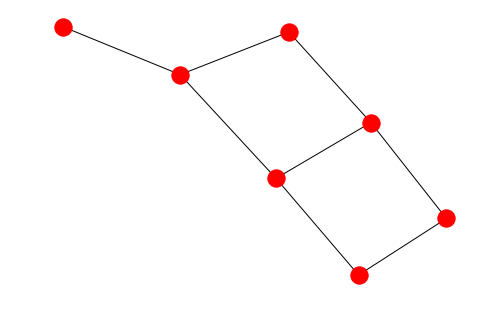

[(1, 2), (1, 3), (2, 4), (3, 4), (4, 6), (5, 6), (5, 7)]


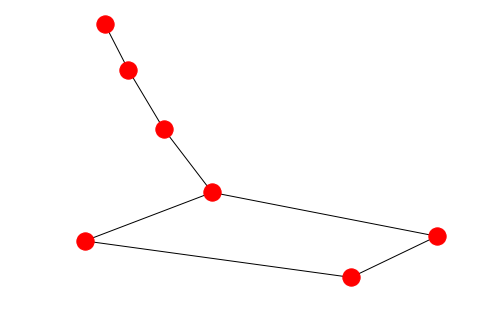

[(1, 2), (1, 3), (2, 4), (3, 4), (5, 6), (5, 7)]


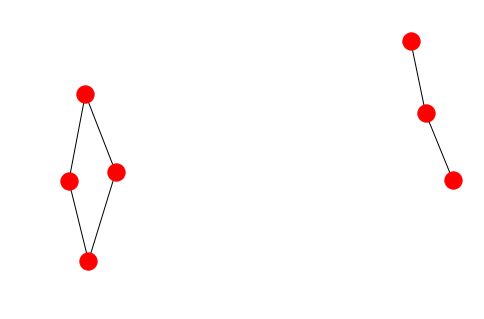

[(1, 3), (2, 4), (3, 4), (5, 6), (5, 7)]


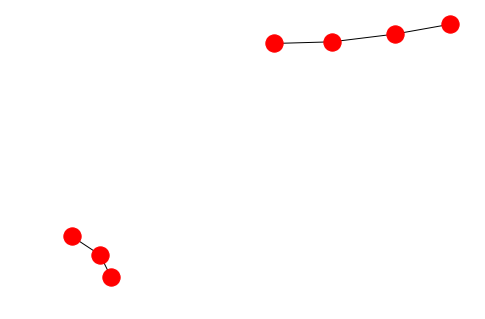

[(1, 3), (2, 4), (5, 6), (5, 7)]


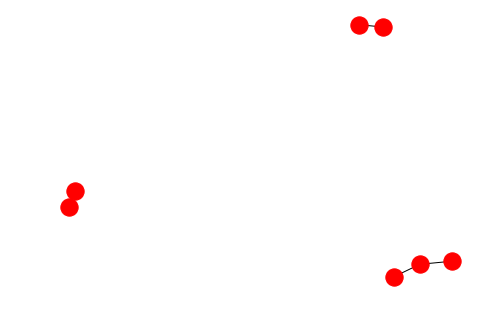

[(1, 3), (2, 4), (5, 7)]


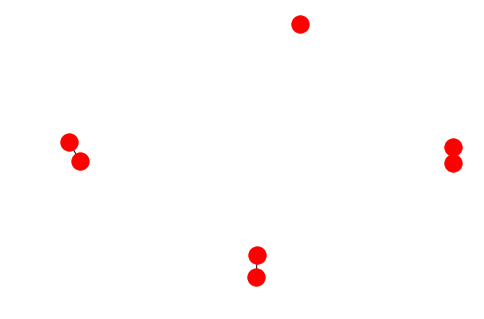

[(2, 4), (5, 7)]


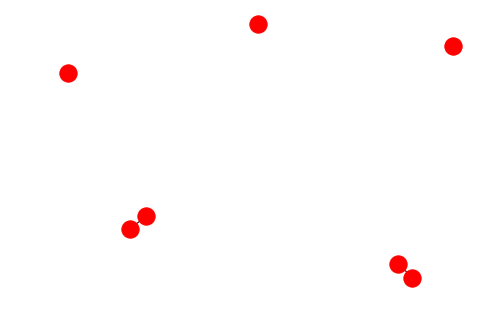

[(5, 7)]


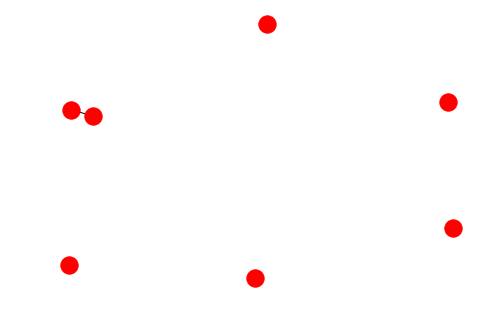

[]


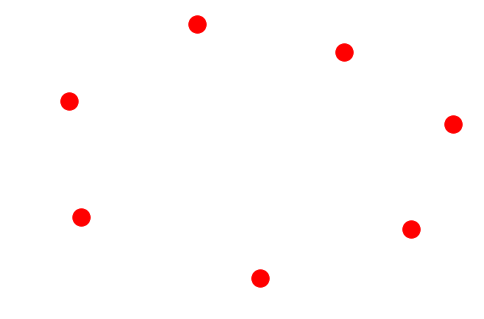

In [125]:
import matplotlib.pyplot as plt
import networkx as nx

def readGraphFrom():
    #read graph from txt file
    G = nx.read_edgelist("graph.txt", create_using=nx.Graph(), nodetype=int)
    return G

def _partialEdgeBetweenness(G):
    SPG = nx.Graph()
    for root in G:
        #print(root)
        for vertex in G:
            for shortest_path in nx.all_shortest_paths(G, source=vertex, target=root):
                #print(shortest_path)
                 SPG.add_path(shortest_path)
                #print([p for p in nx.all_shortest_paths(G, source=vertex, target=1)])
        #nx.draw(SPG)
        #plt.show()

        #for node in SPG:
            #attrs = {node: {'distance': 0, 'weight': 1}}
            #nx.set_node_attributes(SPG, attrs)
        
        max_distance = 0
        for node in SPG:
            if node == root:
                SPG.nodes[node]['distance'] = 0
                SPG.nodes[node]['weight'] = 1
            else:
                distance = nx.shortest_path_length(SPG, source=root, target=node)
                if distance > max_distance:
                    max_distance = distance
                SPG.nodes[node]['distance'] = distance
                SPG.nodes[node]['weight'] = len(list(nx.all_shortest_paths(SPG, source=root, target=node)))
                #attrs = {node: {'distance': distance, 'weight': len(list(nx.all_shortest_paths(SPG, source=root, target=node)))}}

        #for node in SPG:
            #print("Node:")
            #print(node)
            #print(SPG.nodes[node]['distance'])
            #print(SPG.nodes[node]['weight'])
            
        #for edge in SPG.edges:
            #attrs = {}
            
        for leaf in SPG:
            if SPG.nodes[leaf]['distance'] == max_distance:
                for node1, node2 in SPG.edges(leaf):
                    if node1 == leaf:
                        neighbor = node2
                    else:
                        neighbor = node1
                    SPG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
                    #attrs = {(node1, node2): {root: SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']}}
                    #nx.set_edge_attributes(SPG, attrs)


        #print(SPG.edges[5, 6][1])
        #print(SPG.edges[4, 6][1])
        #print(SPG.edges[5, 7][1])
        

        while max_distance > 1:
            max_distance = max_distance-1
            for node in SPG:
                if SPG.nodes[node]['distance'] == max_distance:
                    #print(node)
                    for node1, node2 in SPG.edges(node):
                        if node1 == node:
                            neighborUP = node2
                        else:
                            neighborUP = node1
                        if SPG.nodes[neighborUP]['distance'] == max_distance - 1:
                            sum_of_scores = 0
                            for node11, node22 in SPG.edges(node):
                                if node11 == node:
                                    neighborDOWN = node22
                                else:
                                    neighborDOWN = node11
                                if SPG.nodes[neighborDOWN]['distance'] == max_distance + 1:
                                    sum_of_scores = sum_of_scores + SPG.edges[neighborDOWN, node][root]
                            #print(sum_of_scores)
                            #print((1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight'])
                            SPG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            #attrs = {(node, neighborUP): {root: (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']}}
                            #nx.set_edge_attributes(SPG, attrs)

    #for node1, node2 in SPG.edges:
    #    print(node1, node2)
    #    print(SPG.get_edge_data(node1, node2))
    return SPG

def edgeBetweenness(G, node1, node2):
    NG = G.copy()
    for component in nx.connected_component_subgraphs(NG):
        print("Number of componeents:")
        print(nx.number_connected_components(NG))
        #print("Component:")
        #nx.draw(component)
        if component.has_node(node1) or component.has_node(node2) or (node1 == 0 and node2 == 0):
            print("true")
            SPG = _partialEdgeBetweenness(component)
            for edge in SPG.edges:
                SPG.edges[edge]['weight'] = 0
                for root in SPG:
                    #print(root)
                    #print(edge)
                    #print(SPG.edges[edge][root])
                    #print("Root", root, "-> ", SPG.edges[edge]['weight'], "=", SPG.edges[edge][root], "+",SPG.edges[edge]['weight'])
                    SPG.edges[edge]['weight'] = SPG.edges[edge]['weight'] + SPG.edges[edge][root]
            #print("The edge", edge, "weight", SPG.edges[edge]['weight'])
            
            for edge in SPG.edges:
                NG.edges[edge]['weight'] = SPG.edges[edge]['weight']
                    
    #for node1, node2 in SPG.edges:
    #    print(node1, node2)
    #    print(SPG.get_edge_data(node1, node2))
        
    for node1, node2 in NG.edges:
        print(node1, node2)
        print(NG.get_edge_data(node1, node2))
    return NG
    
def maxScoreEdge(G):
    maxScore = 0.0
    for edge in G.edges:
        if maxScore < G.edges[edge]['weight']:
            maxScore = G.edges[edge]['weight']
            edgeRemove = edge
    return edgeRemove

def removeEdge(edge, G):
    print(edge[0], edge[1])
    G.remove_edge(edge[0], edge[1])
    return G


G = readGraphFrom()
nx.draw(G)
plt.show()
Graphs = [G]
print("Graphs")
for g in Graphs:
    print(g.edges)

num_iter = len(G.edges)
print(num_iter)

e = (0, 0)
NG = G.copy()

while num_iter > 0:
    num_iter = num_iter - 1
    print("EDGE_REMOVED:")
    print(e)
    NG = edgeBetweenness(NG, e[0], e[1])
    e = maxScoreEdge(NG)
    removeEdge(e, NG)
    Graphs.append(NG)
    print("Graphs:")
    for g in Graphs:
        print(g.edges)
        
for g in Graphs:
        print(g.edges)
        nx.draw(g)
        plt.show()